In [41]:
library(tidyverse)
library(limma)
library(data.table)
library(glue)
library(gridExtra)
library(patchwork)

In [42]:
filter_na_proteins <- function(dt, meta_data) {
    # Filter out proteins that have NAs in all columns - 2 (only two non NA)
    dt <- dt[!rowSums(is.na(dt[, (meta_data$Quantitative.column.name)])) > length(meta_data$Quantitative.column.name) - 2,]
    return(dt)
}


In [43]:
pca_plot <- function(df, batch_info, title, 
                     path = "", 
                     quantitative_col_name = "Quantitative.column.name", 
                     col_col = "Group", 
                     shape_col = "Center") {
  pca <- prcomp(t(na.omit(df)))
  pca_df <- pca$x %>%
    as.data.frame() %>%
    rownames_to_column(quantitative_col_name) %>% 
    left_join(batch_info, by = quantitative_col_name)
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  pca_plot <- pca_df %>%
    ggplot(aes_string(x = "PC1", y = "PC2", color = col_col, shape = shape_col)) + # Note: aes_string is deprecated, consider using aes() with !!sym() for newer versions
    geom_point(size=3) +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

  if (path == "") {
    return(pca_plot)
  } else {
    ggsave(path, pca_plot, width = 5, height = 5)
    return(pca_plot)
  }
}

# boxplot
boxplot_pg <- function(protein_matrix, metadata_df, quantitativeColumnName, color_col, title, path) {
  # Reshape data into long format
  long_data <- tidyr::gather(protein_matrix, 
                             key = "file", value = "Intensity")
  merged_data <- merge(long_data, metadata_df, by.x = "file", by.y = quantitativeColumnName)
  
  # Log tranformed scale
  boxplot <- ggplot(merged_data, aes(x = file, y = Intensity, fill = .data[[color_col]])) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 3, color = "red") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    # adjust fonsize for the x-axis
    theme(axis.text.x = element_text(size = 8)) +
    labs(title = title) 

  if(path == "") {
    return(boxplot)
  } else {
      ggsave(path, boxplot)
      return(boxplot)
  }
}

plotIntensityDensityByPool <- function(
    intensities_df, metadata_df, quantitativeColumnName, poolColumnName, title
) {
  # Reshape the intensities_df from wide to long format
  long_intensities <- reshape2::melt(intensities_df, 
    variable.name = "Sample", value.name = "Intensity")
  
  # Adjust the merge function based on your metadata column names
  merged_data <- merge(long_intensities, metadata_df, by.x = "Sample", by.y = quantitativeColumnName)
  
  # Plot the data
  ggplot(merged_data, aes(x = Intensity, color = .data[[poolColumnName]])) +  
    geom_density() +
    theme_minimal() +
    labs(title = paste(title, " by", poolColumnName),
         x = "Intensity",
         y = "Density")
}


In [44]:
# ffrom PRONE.R

medianNorm <- function(dt){
  # find median of each sample
  sample_med <- apply(dt, 2, stats::median, na.rm=TRUE) # columns
  # find mean of medians
  mean_med <- mean(sample_med, na.rm=TRUE)
  # divide data by median
  norm_dt <- t(t(dt)/sample_med)
  # multiply data by mean of medians
  norm_dt <- norm_dt * mean_med
  norm_dt <- data.table::as.data.table(norm_dt)
  colnames(norm_dt) <- colnames(dt)
  rownames(norm_dt) <- rownames(dt)
  return(norm_dt)
}

irsNorm <- function(dt, md, batch, refs){
  # get md of reference samples
  refs_md <- md[md$Quantitative.column.name %in% refs,]
# separate data by batch
  dt_list <- lapply(unique(md[["Pool"]]), function(b){
      md_chunk <- md[md[["Pool"]] == b,]
      dt_chunk <- subset(dt, select = md_chunk$Quantitative.column.name)
      return(dt_chunk)
  })
  names(dt_list) <- unique(md[["Pool"]])
  
  # take reference sample intensities
  irs <- subset(dt, select = refs_md$Quantitative.column.name)
  colnames(irs) <- as.character(refs_md[refs_md$Quantitative.column.name %in% refs,][["Pool"]])
  
  # get the geometric average intensity for each protein
  irs <- tibble::as_tibble(irs)
  irs$average <- apply(irs, 1, function(x) exp(mean(log(x), na.rm=TRUE)))
  # normalize data
  dt_irs_list <- lapply(names(dt_list), function(b){
    # compute scaling factor vectors
    fac <- irs$average / irs[,b]
    # normalize
    dt_irs_chunk <- dt_list[[b]] * fac[,1]
    return(dt_irs_chunk)
  })
  # reconstruct data after irs normalization
  dt_irs <- do.call(cbind, dt_irs_list)
  dt_irs <- data.table::as.data.table(dt_irs)
  dt_irs <- subset(dt_irs, select = colnames(dt))
  
  return(dt_irs)
}

In [45]:
library(ggrepel)

volcano_plot <- function(result, title, show_names=TRUE, show_legend=TRUE) {
  result$P.Value.log <- -log10(result$adj.P.Val)

  volcano_plot <- ggplot(result, aes(x = logFC, y = P.Value.log, color = abs(logFC) > 0.25 & P.Value.log > -log10(0.05))) +
    # add name to the color legeng
    scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black"), 
                        name = "DE proteins") +
    # add line for p-value threshold (0.05) and logFC threshold (1)
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
    geom_vline(xintercept = c(-0.25, 0.25), linetype = "dashed") +
    geom_point() +
    theme_minimal() +
    xlab("Log Fold Change") +
    ylab("-log10 P-value") +
    ggtitle(paste0("Volcano plot for limma results, ", title))

  # if show lgene is False, remove the legend
  if(show_legend == FALSE){
    volcano_plot <- volcano_plot + theme(legend.position = "none")
  }

  if(show_names == TRUE){
    # add names for PG that passed the thresholds -- using rownames as labels
    volcano_plot <- volcano_plot + 
      geom_text_repel(data = result[result$adj.P.Val < 0.05 & abs(result$logFC) > 0.25,], 
                    aes(label = rownames(result[result$adj.P.Val < 0.05 & abs(result$logFC) > 0.25,])), 
                    size = 3) 
  }
  return(volcano_plot)
}

# Load data - Genes from PG

In [46]:
title = "Genes from PG.txt"

In [47]:
path_to_data <- "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/01_PG_Genes/"
centers <- c("Center1", "Center2", "Center3")

############## Read intensities from all centers ##############
intensities_all <- lapply(centers, function(center) {
  read_tsv(file.path(path_to_data, paste0(center, "/genes_intensities.tsv")), show_col_types = FALSE)
})

# print number of rows in each data frame
print(paste("Number of rows in each data frame: ", sapply(intensities_all, nrow)))

# merge intensities using Gene.names column
intensities <- Reduce(function(x, y) {
  full_join(x, y, by = "Gene.names")
}, intensities_all)

intensities <- intensities %>% mutate_all(~replace(., . == 0, NA)) %>%
  column_to_rownames("Gene.names")

print(paste("Number of rows in merged data frame: ", nrow(intensities)))

############## Read metadata from all centers ##############
metadata <- lapply(centers, function(center) {
  read_tsv(file.path(path_to_data, paste0(center, "/metadata.tsv")), 
    col_types = cols(.default = "c"), skip = 1,
    col_names = c("Raw.name", "Quantitative.column.name", "Pool", "Reporter.ion", "Patient", "Group", "Center"))
})
print(paste("Number of rows in each metadata data frame: ", sapply(metadata, nrow)))

# cbind metadata
metadata <- rbindlist(metadata)
print(paste("Number of rows in merged metadata data frame: ", nrow(metadata)))


############## Order column in intensities ##############
intensities <- intensities[,metadata$Quantitative.column.name]

[1] "Number of rows in each data frame:  473"
[2] "Number of rows in each data frame:  504"
[3] "Number of rows in each data frame:  432"
[1] "Number of rows in merged data frame:  606"
[1] "Number of rows in each metadata data frame:  22"
[2] "Number of rows in each metadata data frame:  21"
[3] "Number of rows in each metadata data frame:  22"
[1] "Number of rows in merged metadata data frame:  65"


In [48]:
head(metadata, 2)
head(intensities, 2)

Raw.name,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Reporter.intensity.corrected.1.Pool1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
Reporter.intensity.corrected.2.Pool1,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1


,P_1.RIC_1,P_1.RIC_2,P_1.RIC_3,P_1.RIC_4,P_1.RIC_5,P_1.RIC_6,P_1.RIC_7,P_1.RIC_8,P_1.RIC_9,P_1.RIC_10,⋯,P_6.RIC_2,P_6.RIC_3,P_6.RIC_4,P_6.RIC_5,P_6.RIC_6,P_6.RIC_7,P_6.RIC_8,P_6.RIC_9,P_6.RIC_10,P_6.RIC_11
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,821950,734770,837540,772860,603760,684800,750210,775530,676300,781010,⋯,16985000,15344000,17568000,15650000,16915000,14671000,16319000,16130000,18150000,15035000
A2M,2475200,2514400,2741200,1634700,3682000,1630300,1534500,1744800,2449700,2225900,⋯,15496000,15313000,26161000,13454000,13967000,42095000,12930000,54405000,22753000,16212000


# EDA

In [49]:
cat('Before filtering:', dim(intensities), '\n')
intensities <- filter_na_proteins(intensities, metadata)
cat('After filtering:', dim(intensities))

Before filtering: 606 65 
After filtering: 598 65

In [50]:
# keep only rows if there are at least two non-NA values in each condition
samples_condition_A <- metadata[metadata$Group == "heathy",]$"Quantitative.column.name"
samples_condition_B <- metadata[metadata$Group == "FSGS",]$"Quantitative.column.name"

intensities <- intensities[rowSums(!is.na(intensities[, samples_condition_A])) >= 2 & rowSums(!is.na(intensities[, samples_condition_B])) >= 2,]
cat('After filtering:', dim(intensities))

After filtering: 598 65

In [51]:
# filter rows in intensities if any reference sample column contsin NA
refs <- metadata[metadata$Group == "Common Reference",]$"Quantitative.column.name"
print(length(refs))

cat('Before filtering:', dim(intensities), '\n')
# intensities <- intensities[!rowSums(is.na(intensities[,refs])) > 0,]
# cat('After filtering:', dim(intensities))

[1] 6
Before filtering: 598 65 


No id variables; using all as measure variables



Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_summary()`).”


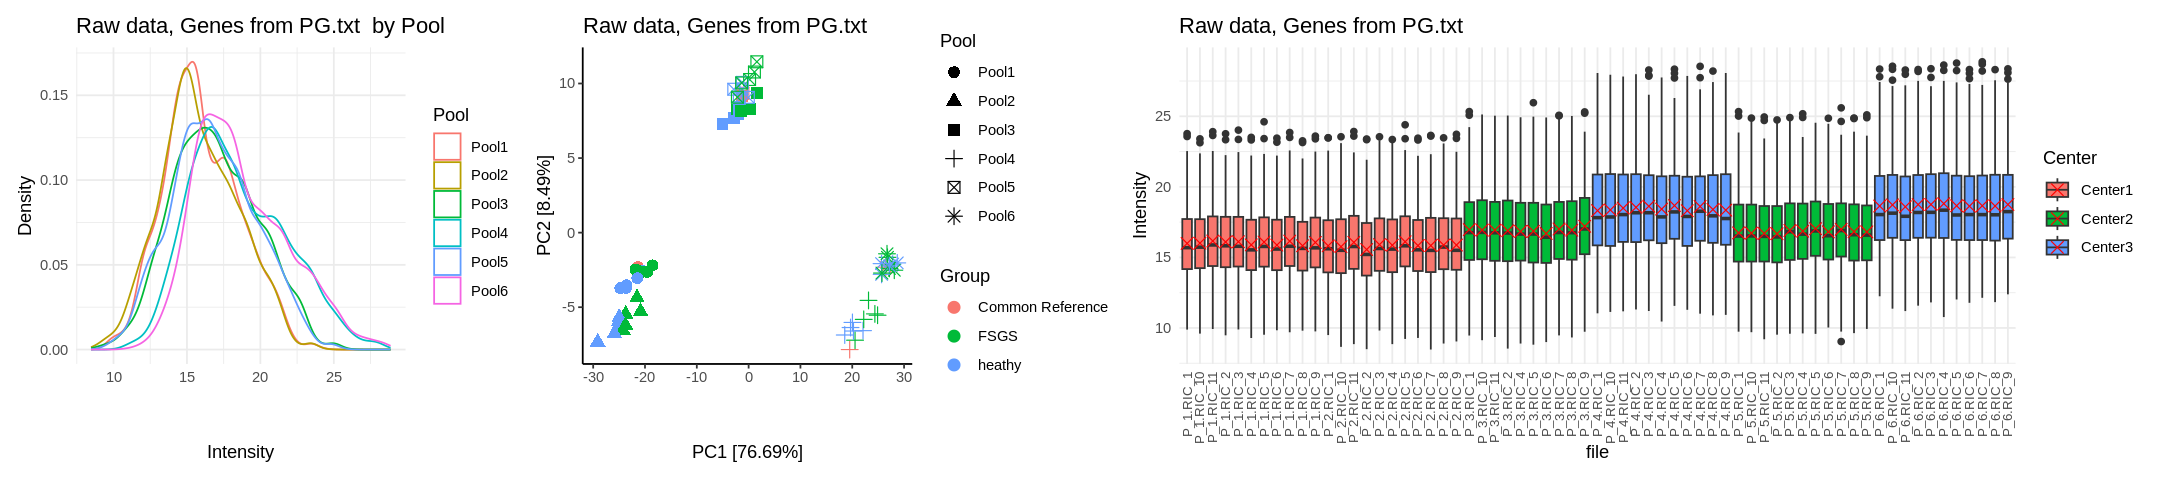

In [19]:
plot_density <- plotIntensityDensityByPool(log2(intensities+1), metadata, "Quantitative.column.name", "Pool", paste0("Raw data, ", title))
plot_pca <- pca_plot(log2(intensities+1), metadata, paste0("Raw data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(intensities+1), metadata, "Quantitative.column.name", "Center", paste0("Raw data, ", title), "")


layout <- (plot_density + plot_pca) | (plot_boxplot)
options(repr.plot.width=18, repr.plot.height=4)
print(layout)

# Test normalizations

## Median

In [25]:
medianNorm_intensities <- medianNorm(intensities)

No id variables; using all as measure variables



Warning message:
“Removed 10251 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_summary()`).”


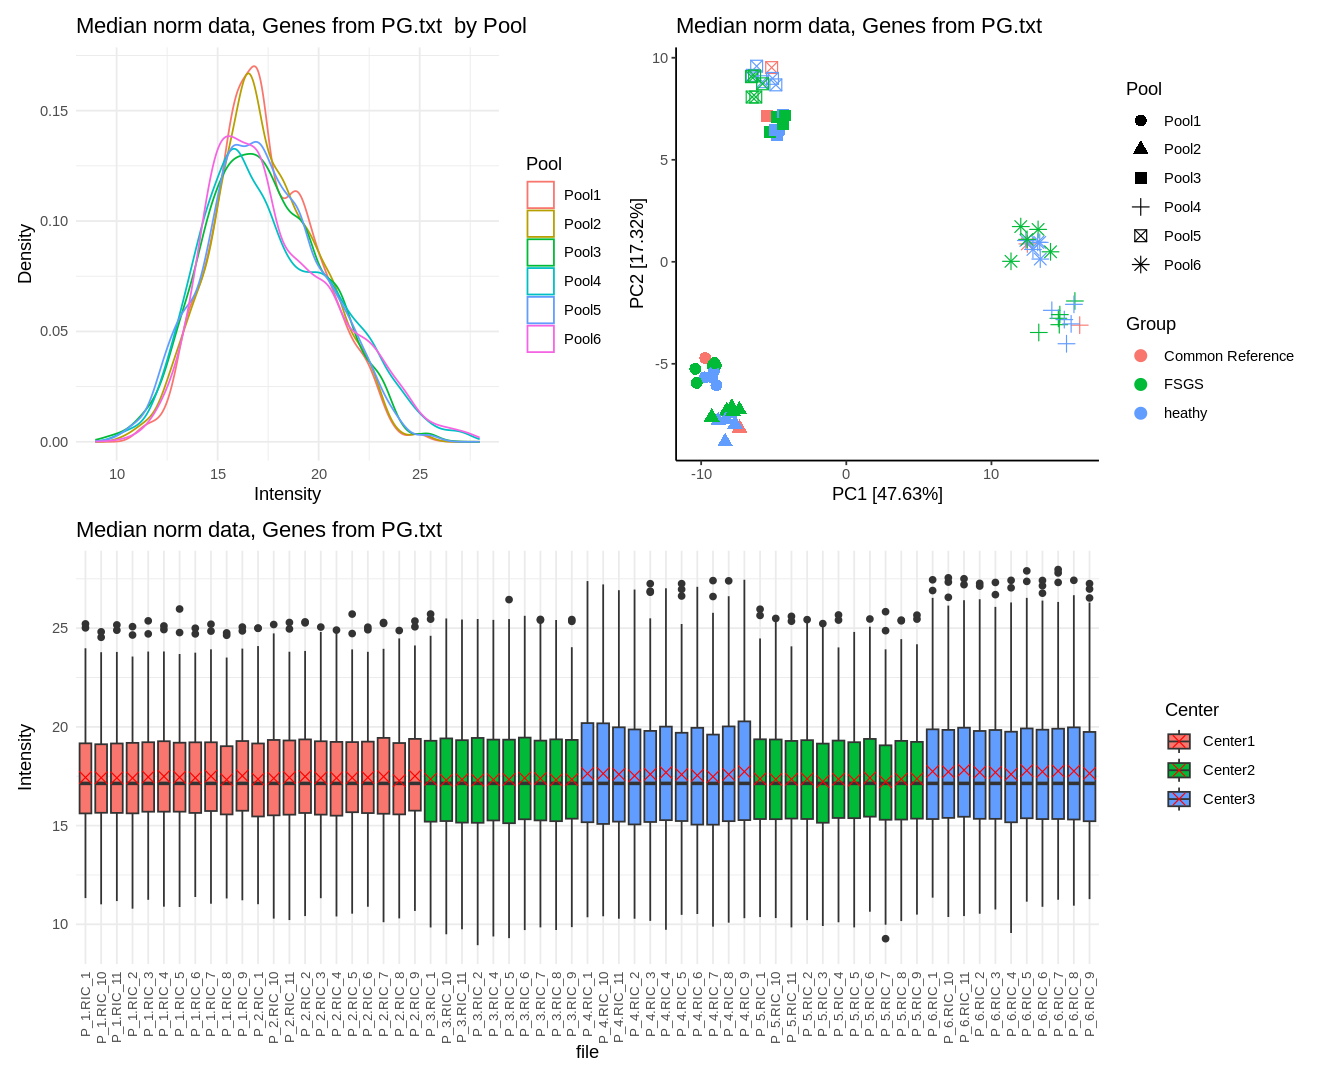

In [26]:
plot_density <- plotIntensityDensityByPool(log2(medianNorm_intensities+1), metadata, "Quantitative.column.name", "Pool", paste0("Median norm data, ", title))
plot_pca <- pca_plot(log2(medianNorm_intensities+1), metadata, paste0("Median norm data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(medianNorm_intensities+1), metadata, "Quantitative.column.name", "Center", paste0("Median norm data, ", title), "")


layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)

Warning message:
“Removed 10251 rows containing non-finite values (`stat_density()`).”


Warning message:
“Removed 10251 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_summary()`).”


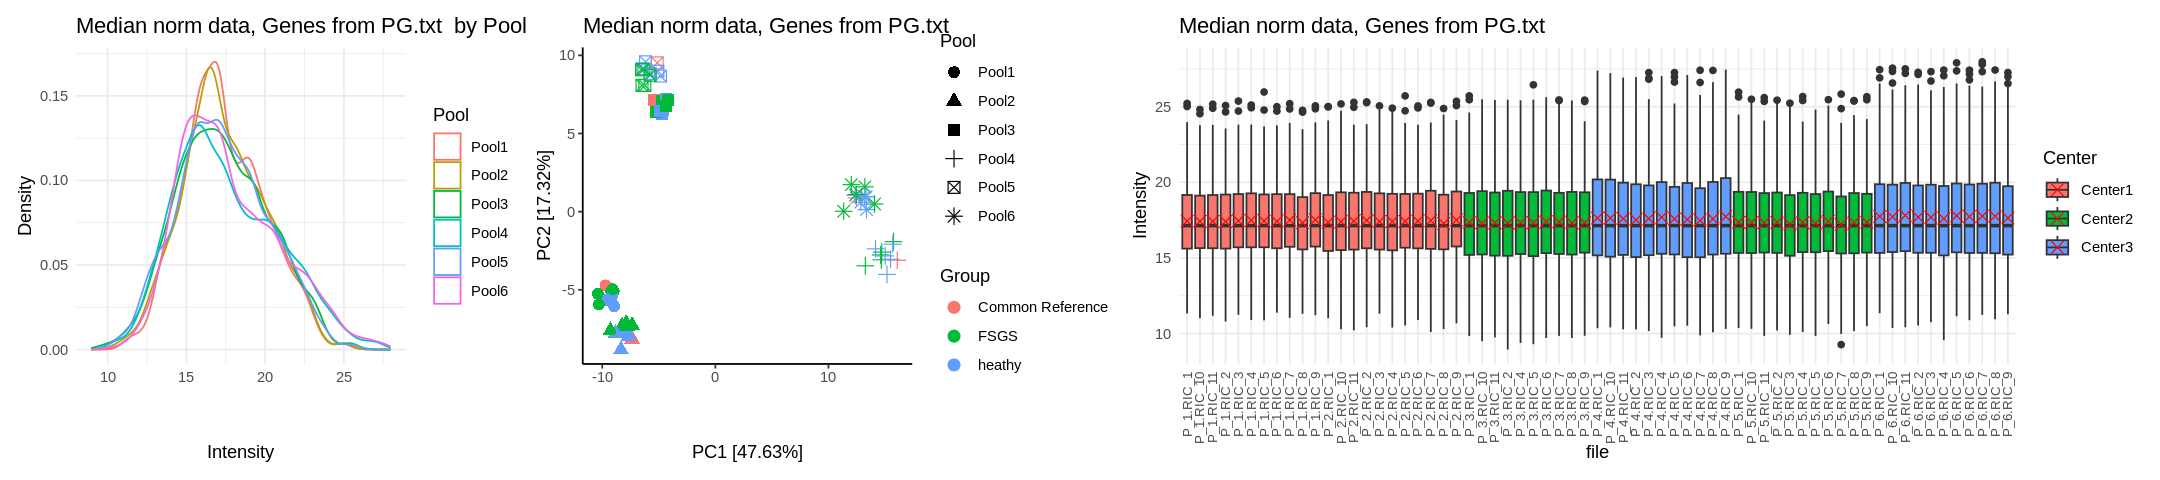

In [27]:

layout <- (plot_density + plot_pca) | (plot_boxplot)
options(repr.plot.width=18, repr.plot.height=4)
print(layout)

## irs on median

In [28]:
ref_samples <- metadata[metadata$Group == 'Common Reference',]$Quantitative.column.name
batch <- metadata$Pool

irs_on_medenianNorm_intensities <- irsNorm(medianNorm_intensities, metadata, batch, ref_samples)


No id variables; using all as measure variables



Warning message:
“Removed 10270 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_summary()`).”


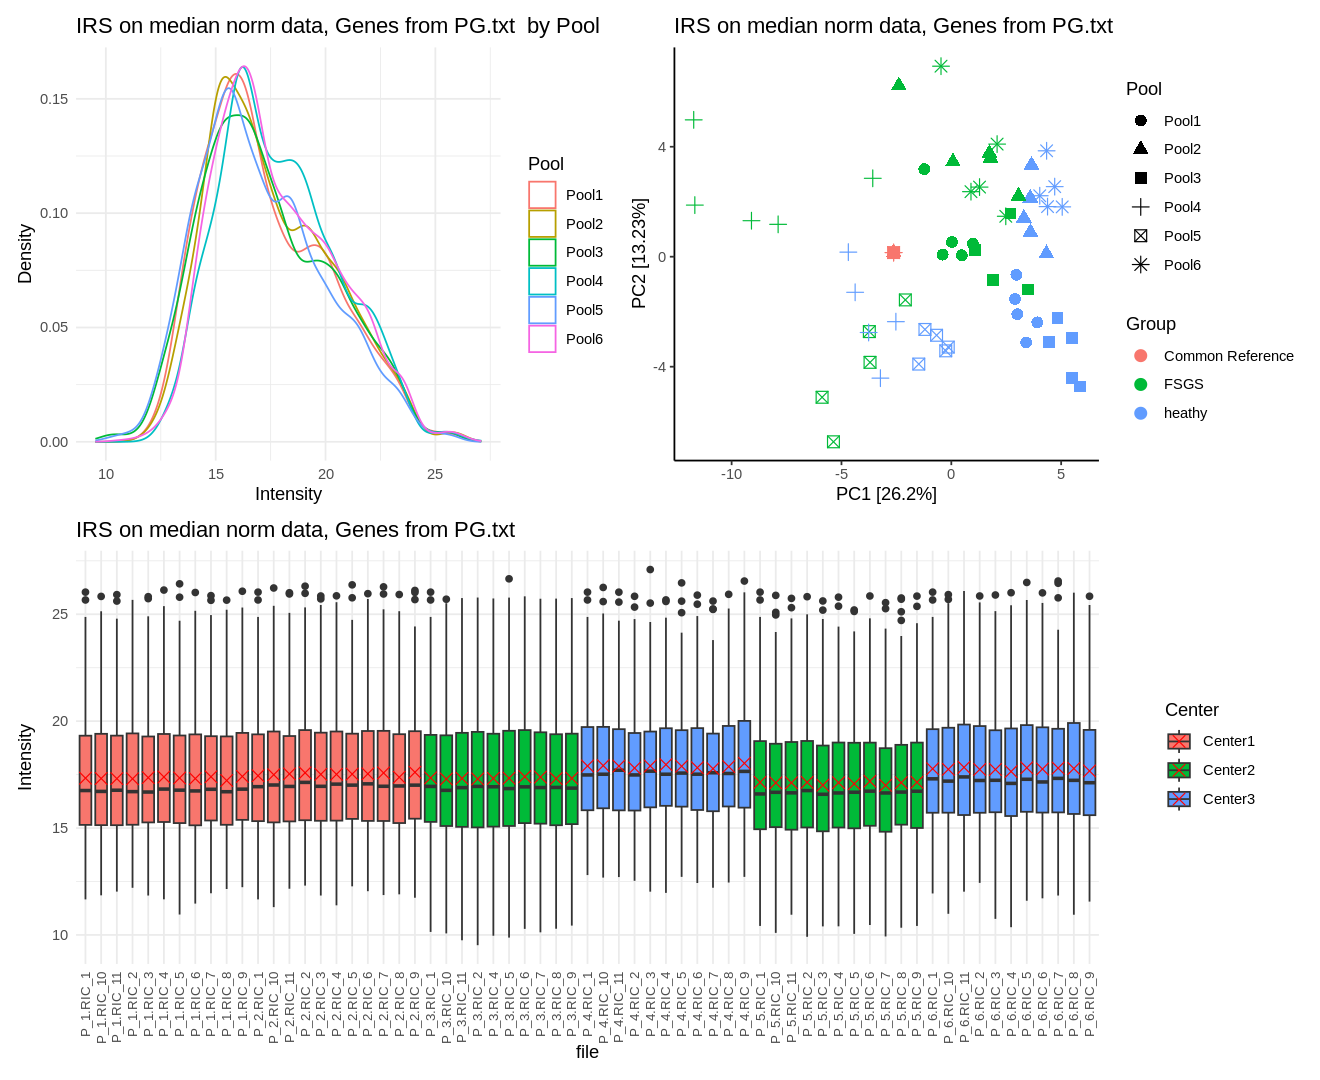

In [29]:
plot_density <- plotIntensityDensityByPool(log2(irs_on_medenianNorm_intensities+1), metadata, "Quantitative.column.name", "Pool", paste0("IRS on median norm data, ", title))
plot_pca <- pca_plot(log2(irs_on_medenianNorm_intensities+1), metadata, paste0("IRS on median norm data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(irs_on_medenianNorm_intensities+1), metadata, "Quantitative.column.name", "Center", paste0("IRS on median norm data, ", title), "")


layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)

In [30]:
irs_on_medenianNorm_intensities_inside_list <- NULL

for (center in centers) {
  ref_samples <- metadata[metadata$Group == 'Common Reference' & metadata$Center == center,]$Quantitative.column.name
  batch <- metadata[metadata$Center == center,]$Pool
  medianNorm_intensities_tmp <- select(medianNorm_intensities, metadata[metadata$Center == center,]$Quantitative.column.name)
  irs_on_medenianNorm_intensities_inside_list[[center]] <- irsNorm(medianNorm_intensities_tmp, metadata[metadata$Center == center,], batch, ref_samples)
}
irs_on_medenianNorm_intensities_inside <- do.call(cbind, irs_on_medenianNorm_intensities_inside_list)
colnames(irs_on_medenianNorm_intensities_inside) <- colnames(medianNorm_intensities)
dim(irs_on_medenianNorm_intensities_inside)

[1] 598  65

No id variables; using all as measure variables



Warning message:
“Removed 10270 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_summary()`).”


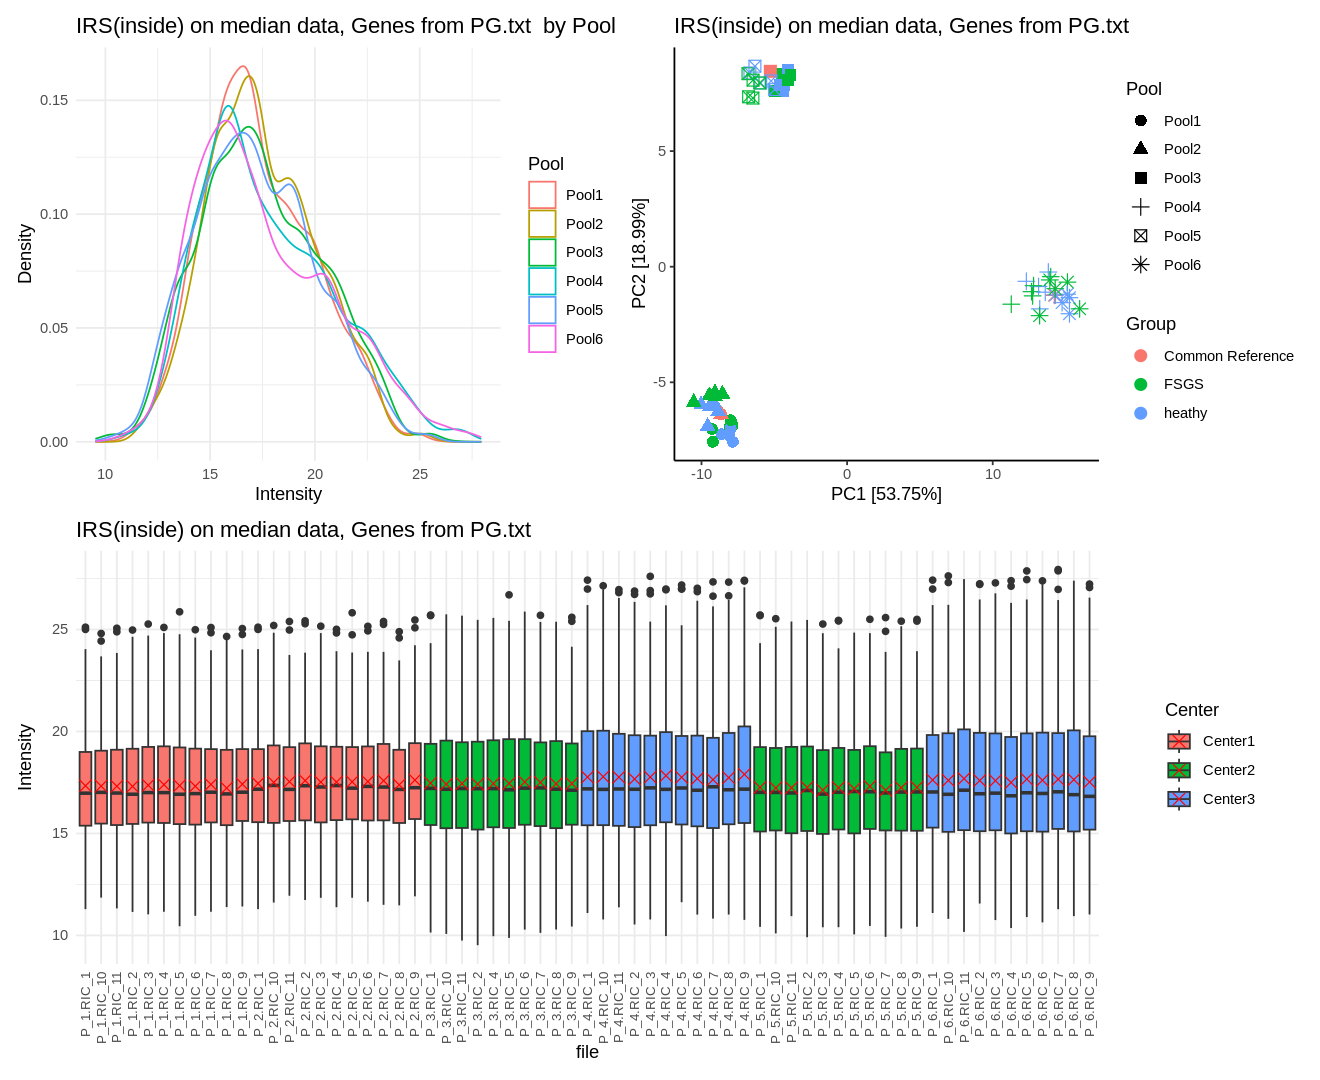

In [31]:
plot_density <- plotIntensityDensityByPool(log2(irs_on_medenianNorm_intensities_inside+1), metadata, "Quantitative.column.name", "Pool", paste0("IRS(inside) on median data, ", title))
plot_pca <- pca_plot(log2(irs_on_medenianNorm_intensities_inside+1), metadata, paste0("IRS(inside) on median data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(irs_on_medenianNorm_intensities_inside+1), metadata, "Quantitative.column.name", "Center", paste0("IRS(inside) on median data, ", title), "")


layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)

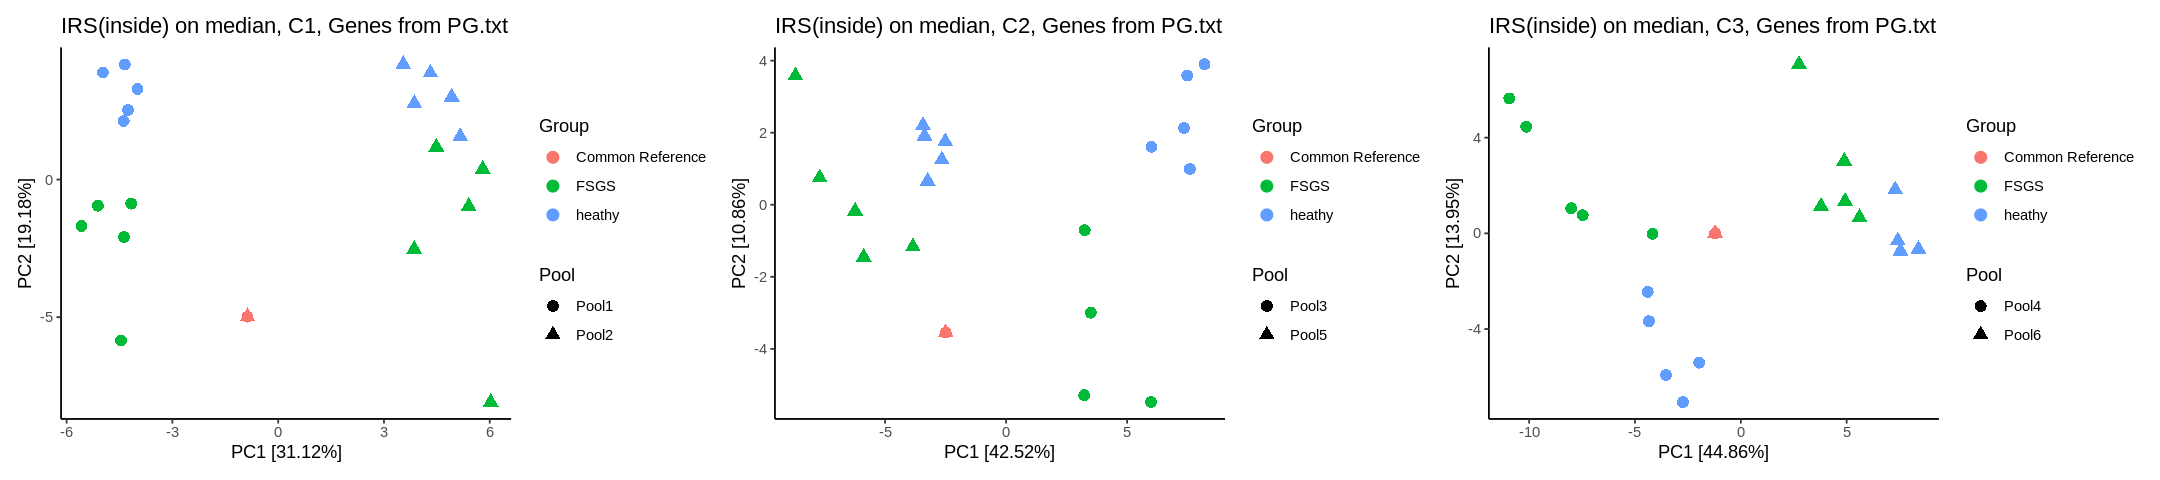

In [32]:
pca_center1_irs_on_median <- pca_plot(log2(irs_on_medenianNorm_intensities_inside_list$Center1+1), metadata[metadata$Center == "Center1",], paste0("IRS(inside) on median, C1, ", title), shape_col = "Pool")
pca_center2_irs_on_median <- pca_plot(log2(irs_on_medenianNorm_intensities_inside_list$Center2+1), metadata[metadata$Center == "Center2",], paste0("IRS(inside) on median, C2, ", title), shape_col = "Pool")
pca_center3_irs_on_median <- pca_plot(log2(irs_on_medenianNorm_intensities_inside_list$Center3+1), metadata[metadata$Center == "Center3",], paste0("IRS(inside) on median, C3, ", title), shape_col = "Pool")

layout <- (pca_center1_irs_on_median | pca_center2_irs_on_median | pca_center3_irs_on_median)
options(repr.plot.width=18, repr.plot.height=4)
print(layout)


No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



Warning message:
“Removed 3136 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 2682 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 4452 rows containing non-finite values (`stat_density()`).”


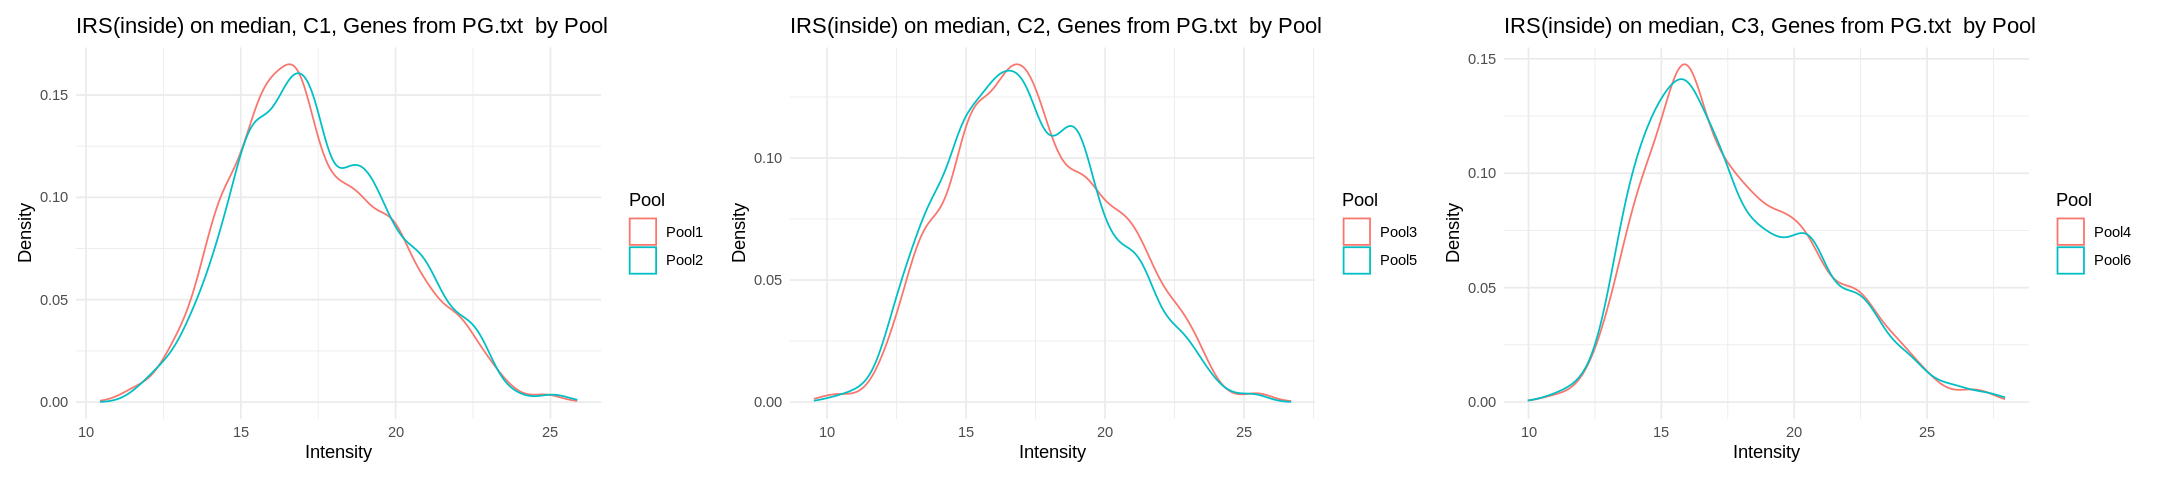

In [33]:
density_plot_center1_irs_on_median <- plotIntensityDensityByPool(log2(irs_on_medenianNorm_intensities_inside_list$Center1+1), metadata[metadata$Center == "Center1",], "Quantitative.column.name", "Pool", paste0("IRS(inside) on median, C1, ", title))
density_plot_center2_irs_on_median <- plotIntensityDensityByPool(log2(irs_on_medenianNorm_intensities_inside_list$Center2+1), metadata[metadata$Center == "Center2",], "Quantitative.column.name", "Pool", paste0("IRS(inside) on median, C2, ", title))
density_plot_center3_irs_on_median <- plotIntensityDensityByPool(log2(irs_on_medenianNorm_intensities_inside_list$Center3+1), metadata[metadata$Center == "Center3",], "Quantitative.column.name", "Pool", paste0("IRS(inside) on median, C3, ", title))

layout <- (density_plot_center1_irs_on_median | density_plot_center2_irs_on_median | density_plot_center3_irs_on_median)
options(repr.plot.width=18, repr.plot.height=4)
print(layout)

## limma

In [34]:
# bacth effects correction
design <- model.matrix(~0 + metadata$Group)
head(design)

batch <- metadata$Pool

,metadata$GroupCommon Reference,metadata$GroupFSGS,metadata$Groupheathy
1,1,0,0
2,0,0,1
3,0,1,0
4,0,0,1
5,0,1,0
6,0,0,1


Warning message:
“Partial NA coefficients for 279 probe(s)”
No id variables; using all as measure variables



Warning message:
“Removed 10251 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_summary()`).”


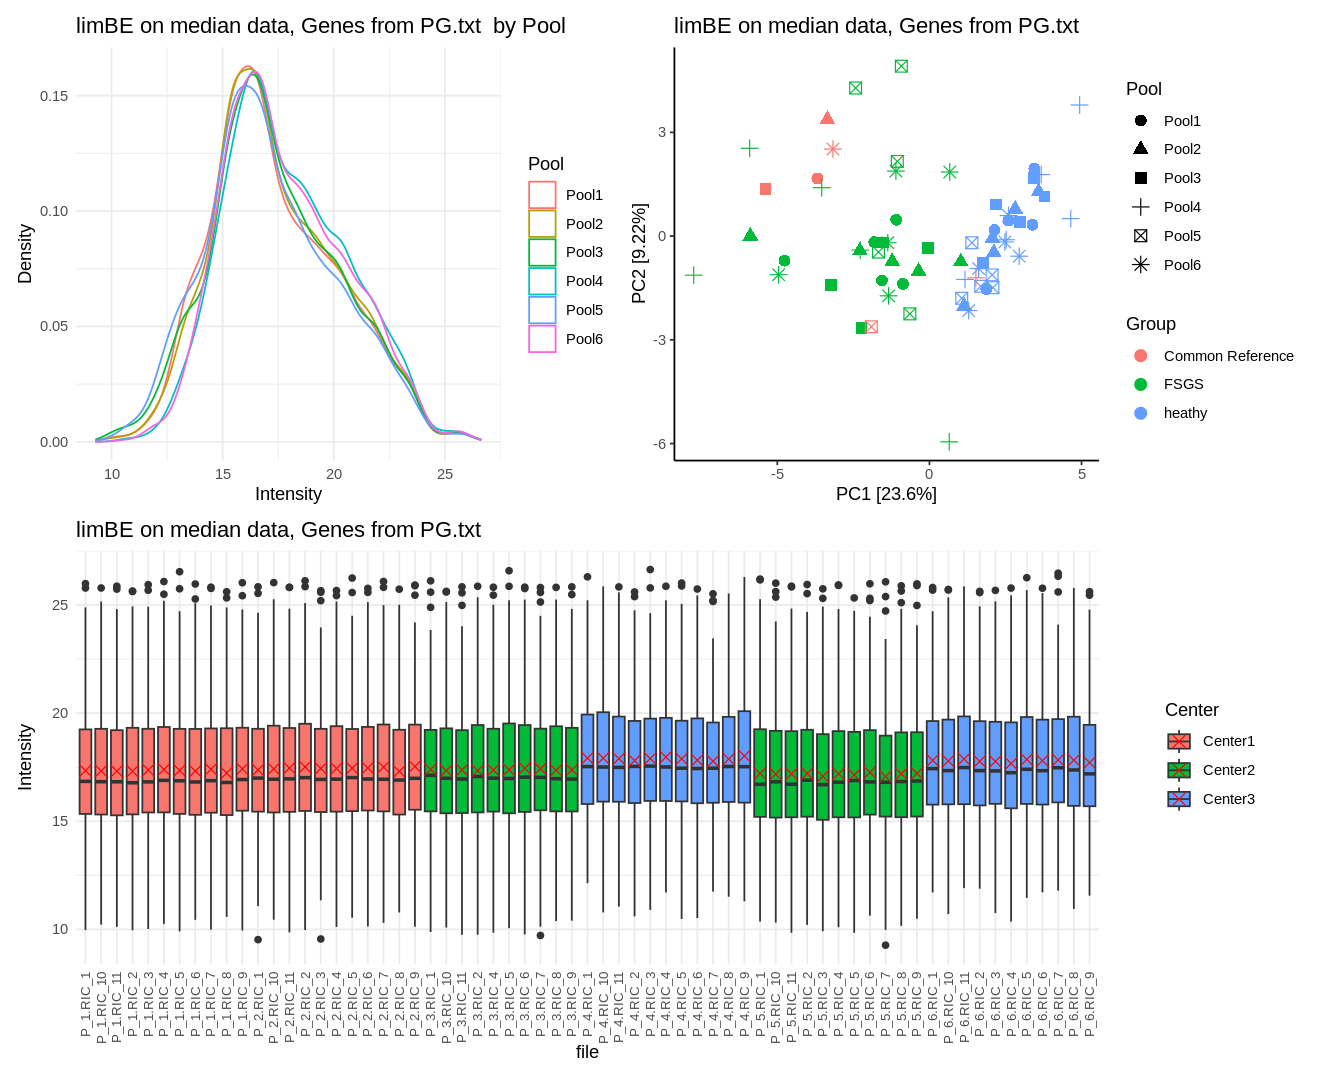

In [35]:
limBE_on_median <- limma::removeBatchEffect(log2(medianNorm_intensities + 1), batch = batch, design = design) %>%
    as.data.frame()
rownames(limBE_on_median) <- rownames(medianNorm_intensities)

plot_density <- plotIntensityDensityByPool(limBE_on_median, metadata, "Quantitative.column.name", "Pool", paste0("limBE on median data, ", title))
plot_pca <- pca_plot(limBE_on_median, metadata, paste0("limBE on median data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(limBE_on_median, metadata, "Quantitative.column.name", "Center", paste0("limBE on median data, ", title), "")

layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)


In [36]:
# on all IRS
limBE_on_iRSall_on_median <- limma::removeBatchEffect(log2(irs_on_medenianNorm_intensities + 1), batch, design = design) %>% as.data.frame()
rownames(limBE_on_iRSall_on_median) <- rownames(irs_on_medenianNorm_intensities)
# on inside IRS
limBE_on_iRSinside_on_median <- limma::removeBatchEffect(log2(irs_on_medenianNorm_intensities_inside + 1), batch, design = design) %>% as.data.frame()
rownames(limBE_on_iRSinside_on_median) <- rownames(irs_on_medenianNorm_intensities_inside)

Warning message:
“Partial NA coefficients for 279 probe(s)”
Warning message:
“Partial NA coefficients for 279 probe(s)”


No id variables; using all as measure variables



Warning message:
“Removed 10270 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_summary()`).”


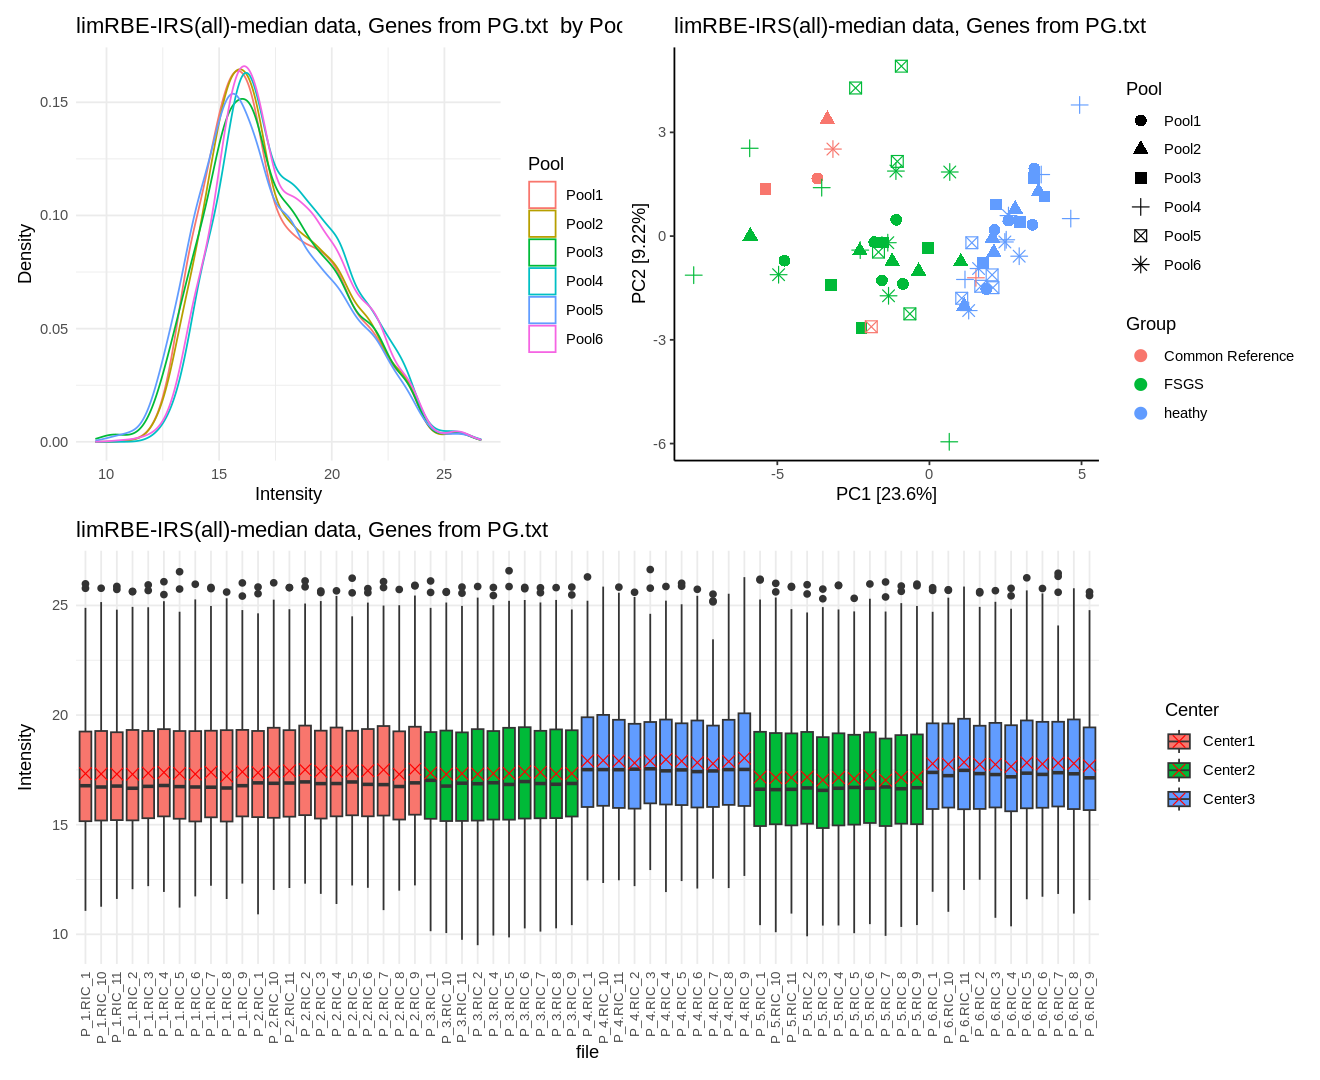

In [37]:
plot_density <- plotIntensityDensityByPool(limBE_on_iRSall_on_median, metadata, "Quantitative.column.name", "Pool", paste0("limRBE-IRS(all)-median data, ", title))
plot_pca <- pca_plot(limBE_on_iRSall_on_median, metadata, paste0("limRBE-IRS(all)-median data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(limBE_on_iRSall_on_median, metadata, "Quantitative.column.name", "Center", paste0("limRBE-IRS(all)-median data, ", title), "")


layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)

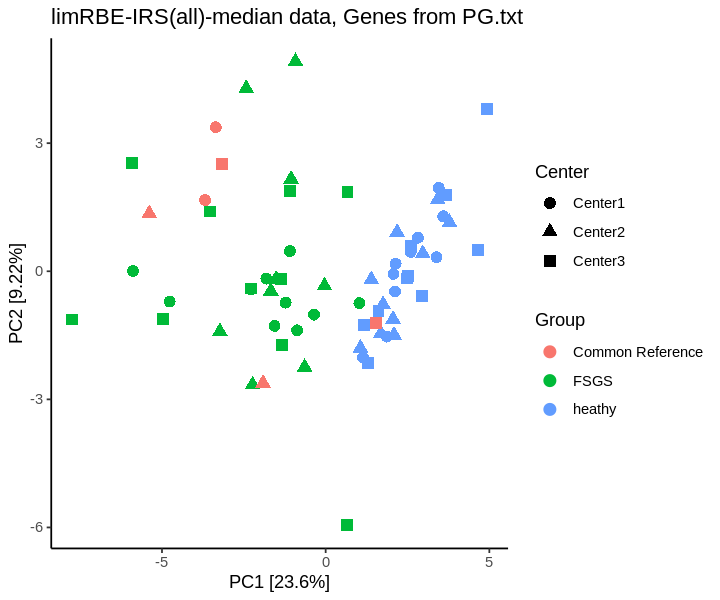

In [38]:
options(repr.plot.width=6, repr.plot.height=5)
pca_plot(limBE_on_iRSall_on_median, metadata, paste0("limRBE-IRS(all)-median data, ", title), shape_col = "Center", col_col = "Group")

No id variables; using all as measure variables

Warning message:
“Removed 10270 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_summary()`).”


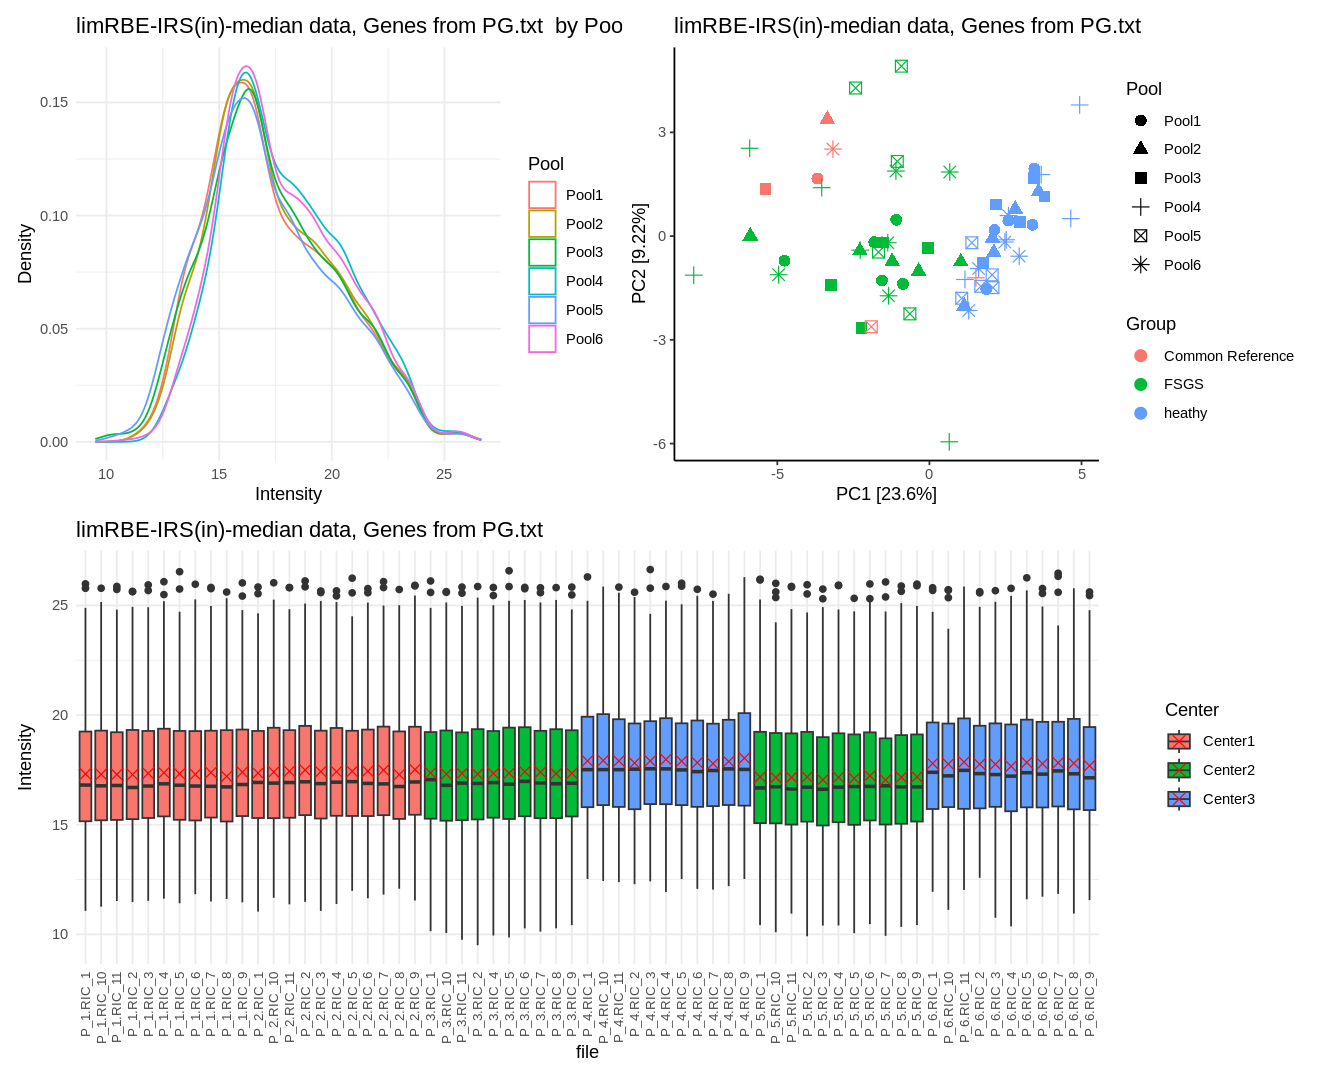

In [39]:
plot_density <- plotIntensityDensityByPool(limBE_on_iRSinside_on_median, metadata, "Quantitative.column.name", "Pool", paste0("limRBE-IRS(in)-median data, ", title))
plot_pca <- pca_plot(limBE_on_iRSinside_on_median, metadata, paste0("limRBE-IRS(in)-median data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(limBE_on_iRSinside_on_median, metadata, "Quantitative.column.name", "Center", paste0("limRBE-IRS(in)-median data, ", title), "")


layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)

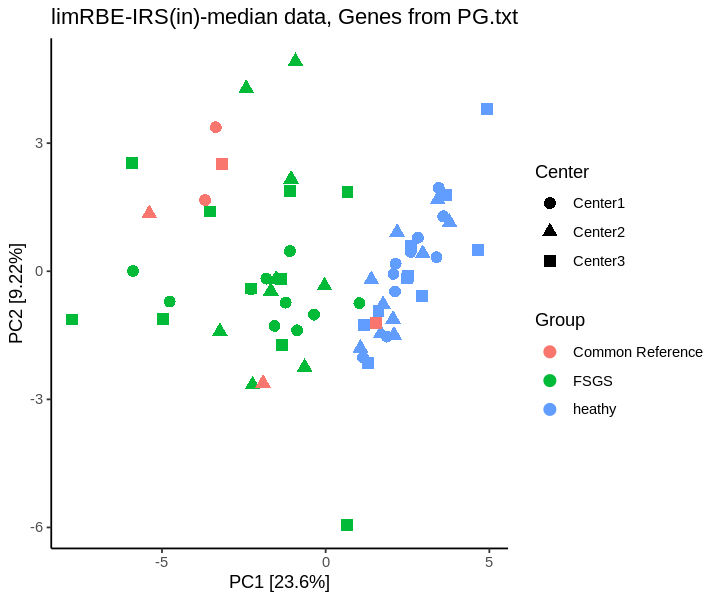

In [40]:
options(repr.plot.width=6, repr.plot.height=5)
pca_plot(limBE_on_iRSinside_on_median, metadata, paste0("limRBE-IRS(in)-median data, ", title), shape_col = "Center", col_col = "Group")

results

In [41]:
limrbe_on_raw <- limma::removeBatchEffect(log2(intensities + 1), batch, design = design) %>% as.data.frame()
rownames(limrbe_on_raw) <- rownames(intensities)

Warning message:
“Partial NA coefficients for 279 probe(s)”


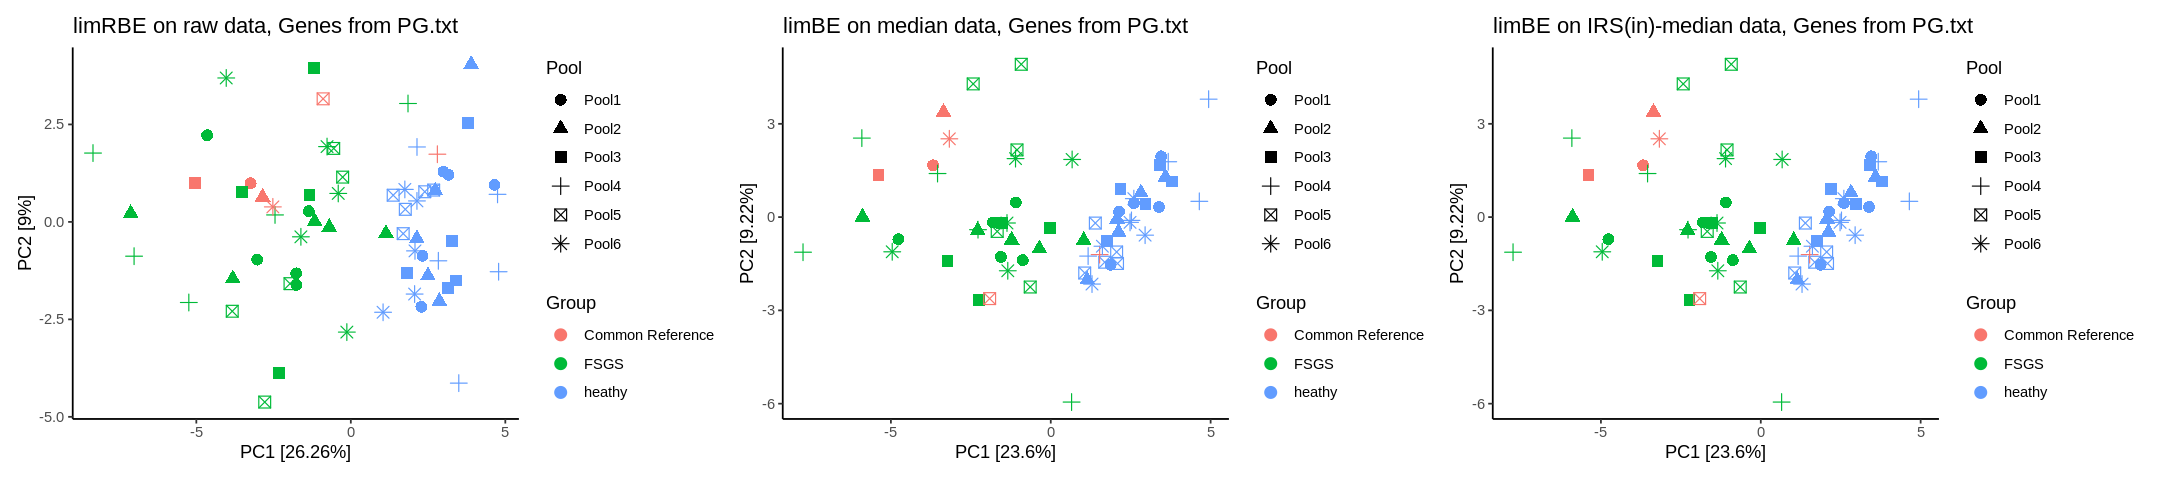

In [42]:
#limrbe on raw pca
pca_1 <- pca_plot(limrbe_on_raw, metadata, paste0("limRBE on raw data, ", title), shape_col = "Pool", col_col = "Group")
# pca for limbec_on_median
pca_2 <- pca_plot(limBE_on_median, metadata, paste0("limBE on median data, ", title), shape_col = "Pool", col_col = "Group")
# pca for limbec_on_iRSinside_on_median
pca_3 <- pca_plot(limBE_on_iRSinside_on_median, metadata, paste0("limBE on IRS(in)-median data, ", title), shape_col = "Pool", col_col = "Group")

layout <- (pca_1 | pca_2 | pca_3)
options(repr.plot.width=18, repr.plot.height=4)
print(layout)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
“Removed 10251 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_density()`).”


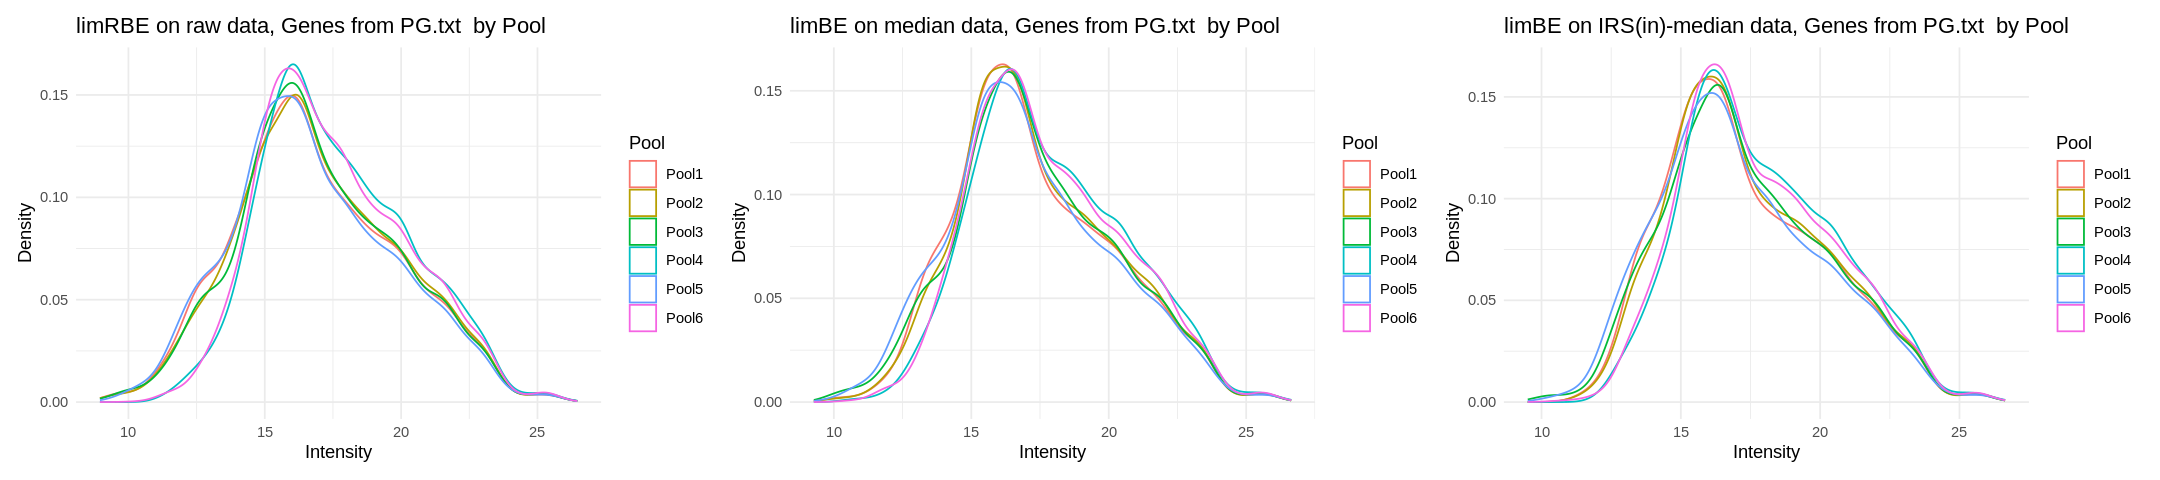

In [43]:
density_1 <- plotIntensityDensityByPool(limrbe_on_raw, metadata, "Quantitative.column.name", "Pool", paste0("limRBE on raw data, ", title))
density_2 <- plotIntensityDensityByPool(limBE_on_median, metadata, "Quantitative.column.name", "Pool", paste0("limBE on median data, ", title))
density_3 <- plotIntensityDensityByPool(limBE_on_iRSinside_on_median, metadata, "Quantitative.column.name", "Pool", paste0("limBE on IRS(in)-median data, ", title))

layout <- (density_1 | density_2 | density_3)
options(repr.plot.width=18, repr.plot.height=4)
print(layout)

Warning message:
“Removed 10251 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10251 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10270 rows containing non-finite values (`stat_summary()`).”


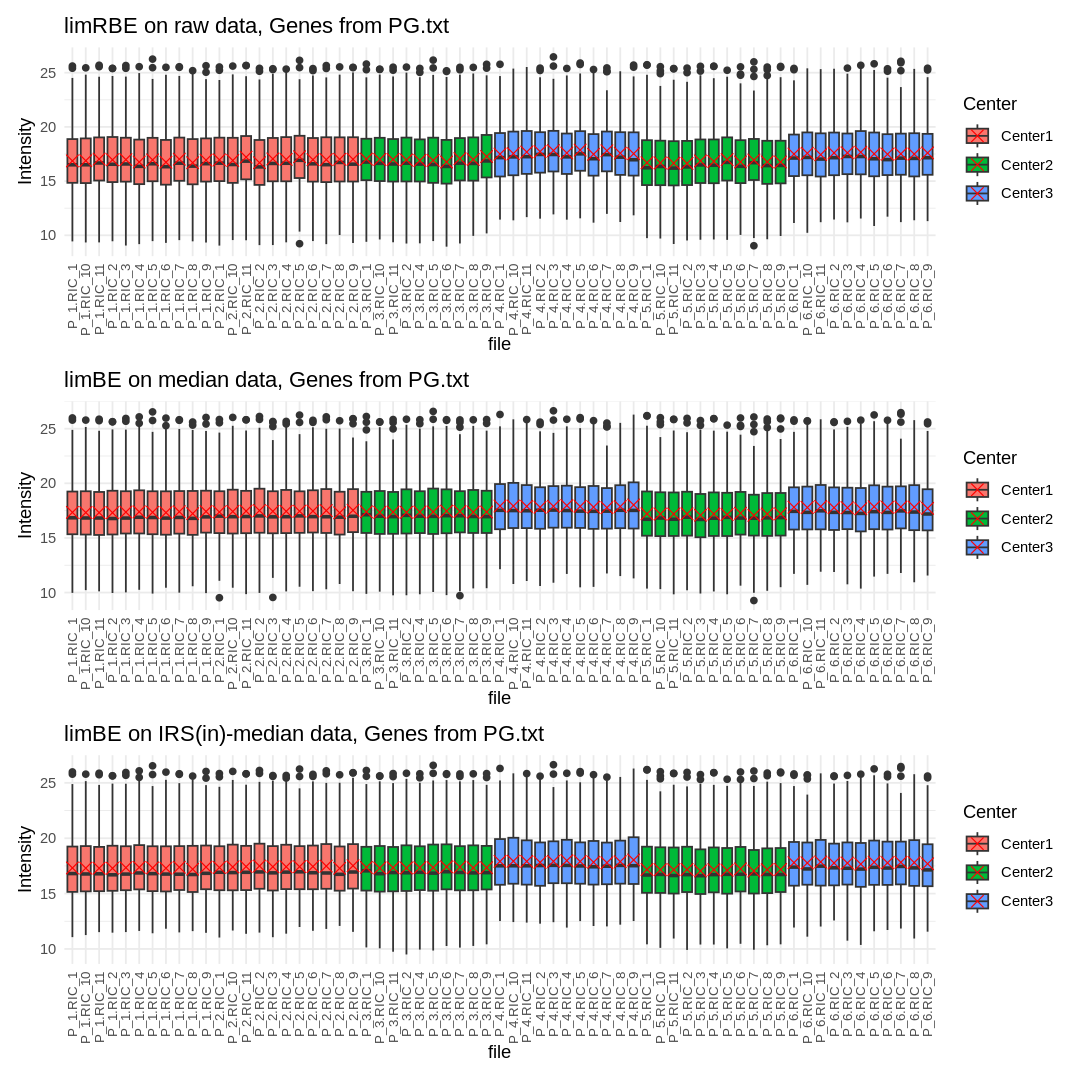

In [44]:
boxplot_1 <- boxplot_pg(limrbe_on_raw, metadata, "Quantitative.column.name", "Center", paste0("limRBE on raw data, ", title), "")
boxplot_2 <- boxplot_pg(limBE_on_median, metadata, "Quantitative.column.name", "Center", paste0("limBE on median data, ", title), "")
boxplot_3 <- boxplot_pg(limBE_on_iRSinside_on_median, metadata, "Quantitative.column.name", "Center", paste0("limBE on IRS(in)-median data, ", title), "")

layout <- (boxplot_1) / 
          (boxplot_2) / 
          (boxplot_3)

options(repr.plot.width=9, repr.plot.height=9)

print(layout)

# DE analysis

### DE on raw data using pools

In [20]:
log_intensities <- log2(intensities + 1)
# remove reference samples
ref_samples <- metadata[metadata$Group == 'Common Reference',]$"Quantitative.column.name"
log_intensities <- log_intensities[,!colnames(log_intensities) %in% ref_samples]
metadata_de <- metadata[!metadata$Group == 'Common Reference',]

metadata_de <- metadata_de %>%
    mutate(Group = as.factor(Group), Pool = as.factor(Pool))

In [21]:
design <- model.matrix(~0 + metadata_de$Group + metadata_de$Pool)
colnames(design) <- c(levels(metadata_de$Group), levels(metadata_de$Pool)[-1])

contrasts <- makeContrasts(FSGS - heathy, levels = colnames(design))

In [22]:

fit <- lmFit(log_intensities, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

results_on_raw <- topTable(fit3, coef=1, adjust="BH", sort.by="none", number=Inf, confint = TRUE)
head(results_on_raw, 2)

Warning message:
“Partial NA coefficients for 279 probe(s)”


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,-0.01981554,-0.10322989,0.0635988,21.20969,-0.4758183,0.63604381,0.71495150,-6.628169
A2M,0.37696126,0.08371662,0.6702059,22.43044,2.5747941,0.01268327,0.02862112,-3.598202


Warning message:
“ggrepel: 163 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


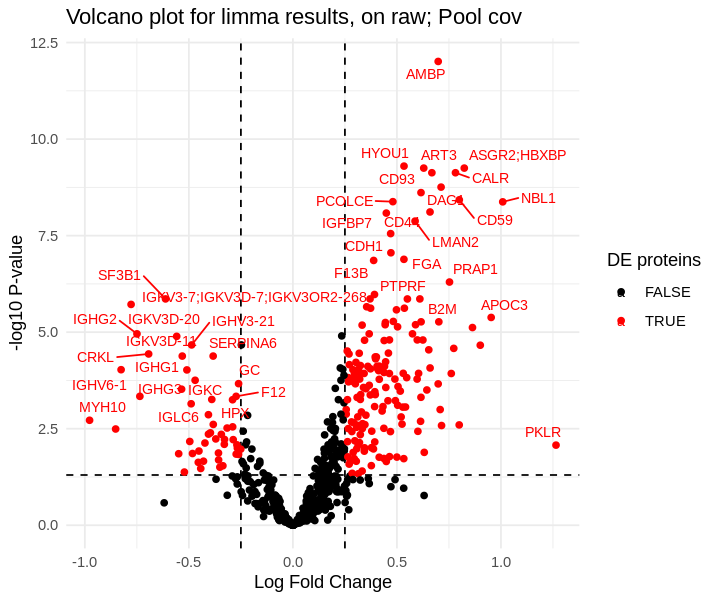

In [23]:
options(repr.plot.width=6, repr.plot.height=5)
volcano_plot(results_on_raw, "on raw; Pool cov")

### DE on median norm using pools

In [37]:
log_median <- log2(medianNorm(intensities) + 1) %>% as.data.frame()
# add rownames
rownames(log_median) <- rownames(intensities)
# remove reference samples
log_median <- log_median[,!colnames(log_median) %in% ref_samples]

In [38]:
fit <- lmFit(log_median, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

results_on_median <- topTable(fit3, coef=1, adjust="BH", sort.by="none", number=Inf, confint = TRUE)
head(results_on_median, 2)

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,-0.2224339,-0.3120398,-0.1328281,21.43087,-4.971075,6.459736e-06,3.481688e-05,3.471790
A2M,0.1743428,-0.1017463,0.4504319,22.65163,1.264562,2.111856e-01,2.919871e-01,-6.030793


Warning message:
“ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


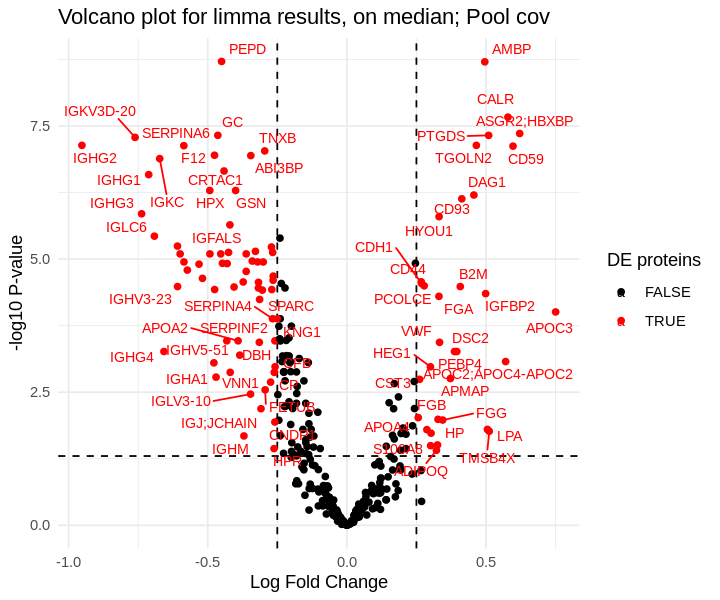

In [39]:
options(repr.plot.width=6, repr.plot.height=5)
volcano_plot(results_on_median, "on median; Pool cov")

In [40]:
log_irs_on_median <- log2(irs_on_medenianNorm_intensities_inside + 1) %>% as.data.frame()
rownames(log_irs_on_median) <- rownames(intensities)
log_irs_on_median <- log_irs_on_median[,!colnames(log_irs_on_median) %in% ref_samples]

In [41]:
fit <- lmFit(log_irs_on_median, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

results_irs_on_median <- topTable(fit3, coef=1, adjust="BH", sort.by="none", number=Inf, confint = TRUE)
head(results_irs_on_median, 2)

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,-0.2224339,-0.3120398,-0.1328281,21.42746,-4.971073,6.459774e-06,3.481709e-05,3.471785
A2M,0.1743428,-0.1017463,0.4504319,22.65301,1.264562,2.111856e-01,2.919870e-01,-6.030793


Warning message:
“ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


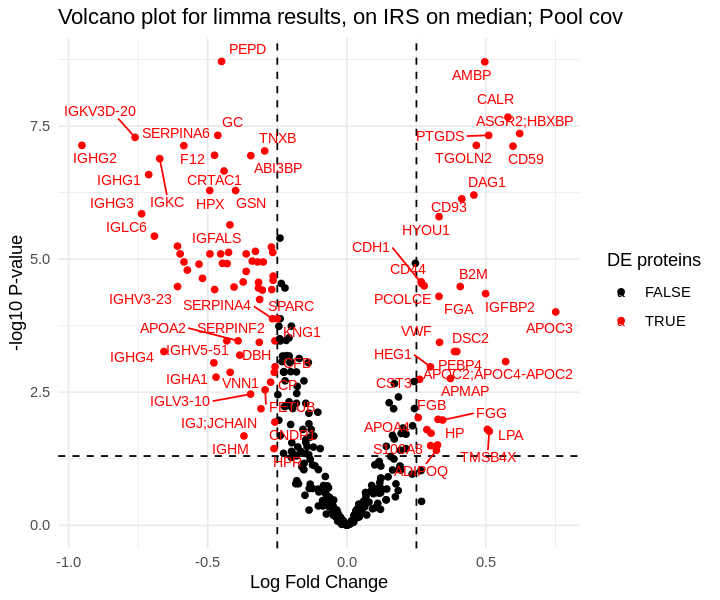

In [42]:
options(repr.plot.width=6, repr.plot.height=5)
volcano_plot(results_irs_on_median, "on IRS on median; Pool cov")

Warning message:
“ggrepel: 94 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 76 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 76 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


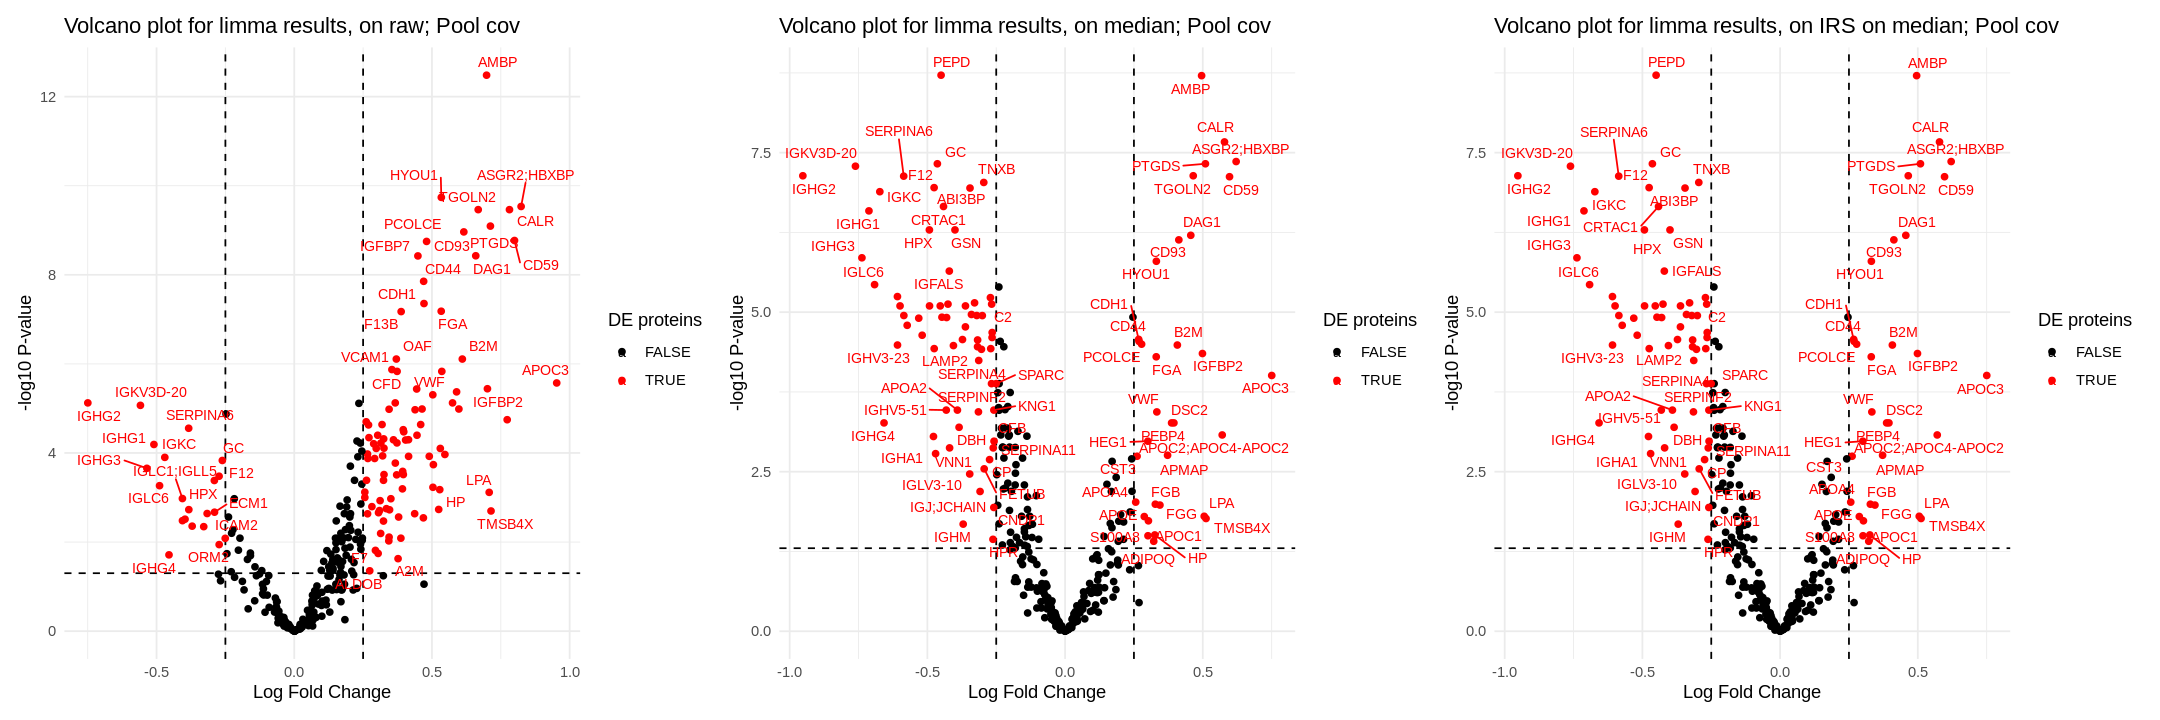

In [43]:
plot_1 <- volcano_plot(results_on_raw, "on raw; Pool cov")
plot_2 <- volcano_plot(results_on_median, "on median; Pool cov")
plot_3 <- volcano_plot(results_irs_on_median, "on IRS on median; Pool cov")

layout <- (plot_1 | plot_2 | plot_3)
options(repr.plot.width=18, repr.plot.height=6)
print(layout)

# Save results
use the median-irs(inside)-DE

In [105]:
library(DEqMS)

In [106]:
medianNorm_intensities <- medianNorm(intensities)
medianNorm_intensities <- medianNorm_intensities %>% as.data.frame()
rownames(medianNorm_intensities) <- rownames(intensities)

In [107]:
counts <- list()

for(center in c("Center1", "Center2", "Center3")) {
  count <- read.csv(file.path('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/01_PG_Genes', center, "genes_counts_v2.tsv"), sep = "\t")
  counts[[center]] <- count
}

# merger three keeping for each gene the minimum value
# so, there is two columns, Gene.names - merge by this, and Unique.peptides -- keep the minimum
counts <- Reduce(function(x, y) {
  merge(x, y, by = "Gene.names") %>%
    mutate(Unique.peptides = pmin(Unique.peptides.x, Unique.peptides.y, na.rm = TRUE)) %>%
    select(-Unique.peptides.x, -Unique.peptides.y)
}, counts) %>%
  column_to_rownames("Gene.names")


# keep only genes in intensities that are in counts (not add new)
# so check if in
cat('Before filtering:', dim(medianNorm_intensities), '\n')
medianNorm_intensities <- medianNorm_intensities[rownames(medianNorm_intensities) %in% rownames(counts),]
cat('After filtering:', dim(medianNorm_intensities))

Before filtering: 598 65 
After filtering: 356 65

In [108]:
irs_on_medenianNorm_intensities_inside_list <- NULL

for (center in centers) {
  ref_samples <- metadata[metadata$Group == 'Common Reference' & metadata$Center == center,]$Quantitative.column.name
  batch <- metadata[metadata$Center == center,]$Pool
  medianNorm_intensities_tmp <- select(medianNorm_intensities, metadata[metadata$Center == center,]$Quantitative.column.name)
  irs_on_medenianNorm_intensities_inside_list[[center]] <- irsNorm(medianNorm_intensities_tmp, metadata[metadata$Center == center,], batch, ref_samples)
}
irs_on_medenianNorm_intensities_inside <- do.call(cbind, irs_on_medenianNorm_intensities_inside_list)
colnames(irs_on_medenianNorm_intensities_inside) <- colnames(medianNorm_intensities)
dim(irs_on_medenianNorm_intensities_inside)

[1] 356  65

In [109]:
ref_samples <- metadata[metadata$Group == 'Common Reference',]$"Quantitative.column.name"
metadata_de <- metadata[!metadata$Group == 'Common Reference',]
metadata_de <- metadata_de %>%
    mutate(Group = as.factor(Group), Pool = as.factor(Pool))

In [111]:
log_irs_on_median <- log2(irs_on_medenianNorm_intensities_inside + 1) %>% as.data.frame()
rownames(log_irs_on_median) <- rownames(medianNorm_intensities)
log_irs_on_median <- log_irs_on_median[,!colnames(log_irs_on_median) %in% ref_samples]
cat('Number of rows in log_irs_on_median:', nrow(log_irs_on_median), '\n')
cat('Number of columns in log_irs_on_median:', ncol(log_irs_on_median), '\n')

Number of rows in log_irs_on_median: 356 
Number of columns in log_irs_on_median: 59 


In [112]:
design <- model.matrix(~0 + metadata_de$Group + metadata_de$Pool)
colnames(design) <- c(levels(metadata_de$Group), levels(metadata_de$Pool)[-1])

contrasts <- makeContrasts(FSGS - heathy, levels = colnames(design))

In [113]:
fit <- lmFit(log_irs_on_median, design)
fit2 <- contrasts.fit(fit, contrasts)
fit3 <- eBayes(fit2)

fit3$count <- counts[rownames(fit3$coefficients), "Unique.peptides"] + 1
if(is.na(min(fit3$count)) | min(fit3$count) == 0){
  print("No DEqMS results")
}

fit4 <- spectraCounteBayes(fit3)
results_irs_on_median <- outputResult(fit4, coef_col = 1)
head(results_irs_on_median, 2)

Warning message:
“Partial NA coefficients for 38 probe(s)”


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,gene,count,sca.t,sca.P.Value,sca.adj.pval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AMBP,0.5931131,0.4806887,0.7055375,21.49048,10.563952,3.087498e-15,1.099149e-12,24.00514,AMBP,19,10.670787,3.087498e-15,1.099149e-12
CALR,0.6762294,0.5348955,0.8175633,17.04100,9.580695,1.889727e-13,3.363714e-11,20.48122,CALR,6,9.548083,1.889727e-13,3.363714e-11


In [114]:
# remove rows with NA 
results_irs_on_median <- results_irs_on_median[!is.na(results_irs_on_median$adj.P.Val),]
dim(results_irs_on_median)

[1] 356  13

In [115]:
common_names <-  lapply(centers, function(center) {
  read.csv(file.path('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/01_PG_Genes', center, "genes_counts_v2.tsv"), sep = "\t")
})

common_names <- Reduce(function(x, y) {
  merge(x, y, by = "Gene.names")
}, common_names)
common_names <- common_names$Gene.names
cat('Number of rows in common_names:', length(common_names), '\n')

Number of rows in common_names: 356 


In [116]:
# save results_irs_on_median to file in tsv format
write.table(results_irs_on_median[common_names,], file = "./Central_res_irs_on_median.tsv", sep = "\t", quote = FALSE, row.names = TRUE)

# Run Meta for selected 

In [86]:
outputResult <-function(fit,coef_col=1){
    results.table = limma::topTable(fit, coef=coef_col, n= Inf, confint=TRUE)
    
    results.table$gene = rownames(results.table)
    results.table$count = fit$count[results.table$gene]
    
    results.table$sca.t = fit$sca.t[results.table$gene,coef_col]
    results.table$P.Value = fit$sca.p[results.table$gene,coef_col]
    results.table$sca.P.Value = fit$sca.p[results.table$gene,coef_col]
    results.table$adj.P.Val = p.adjust(results.table$sca.P.Value, method = "BH")
    results.table$sca.adj.pval = p.adjust(results.table$sca.P.Value, method = "BH")
    results.table = results.table[order(results.table$sca.P.Value), ]
}

In [100]:
metadata_de <- metadata #[!metadata$Group == 'Common Reference',]

plots <- list()

for(center in c("Center1", "Center2", 'Center3')){
    ref_samples <- metadata_de %>%
        filter(Group == 'Common Reference') %>%
        filter(Center == center) %>%
        pull(Quantitative.column.name)
    # metadata_de[metadata_de$Group == 'Common Reference',][metadata_de$Center == center,]$Quantitative.column.name
    center_meta <- metadata_de[metadata_de$Center == center,]

    # prepare counts
    counts <- read.csv(file.path('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/01_PG_Genes', center, "genes_counts_v2.tsv"), sep = "\t")
    counts <- counts %>% column_to_rownames("Gene.names")
    
    # prepare intensities
    center_intensities_non <- intensities[,center_meta$Quantitative.column.name]
    center_intensities <- medianNorm(center_intensities_non)
    center_intensities <- irsNorm(center_intensities, center_meta, center_meta$Pool, ref_samples) %>% as.data.frame()
    rownames(center_intensities) <- rownames(center_intensities_non)
    center_intensities <- center_intensities[rownames(center_intensities) %in% rownames(counts),]


    # exclude reference samples
    center_meta <- center_meta[!center_meta$Quantitative.column.name %in% ref_samples,]
    center_intensities <- center_intensities[,!colnames(center_intensities) %in% ref_samples]
    center_intensities <- log2(center_intensities + 1)
    cat('Shape of metadata for ', center, ' is ', dim(center_meta), '\n')
    cat('Shape of intensities for ', center, ' is ', dim(center_intensities), '\n')


    # prepare contrasts
    center_meta <- center_meta %>%
        mutate(Group = as.factor(Group), Pool = as.factor(Pool))
    design <- model.matrix(~0 + center_meta$Group + center_meta$Pool)
    colnames(design) <- c(levels(center_meta$Group), levels(center_meta$Pool)[-1])
    contrasts <- makeContrasts(FSGS - heathy, levels = colnames(design))

    fit <- lmFit(center_intensities, design)
    fit2 <- contrasts.fit(fit, contrasts)
    fit3 <- eBayes(fit2)

    fit3$count <- counts[rownames(fit3$coefficients), "Unique.peptides"] + 1
    if(is.na(min(fit3$count)) | min(fit3$count) == 0){
        print("No DEqMS results")
        }

    fit4 <- spectraCounteBayes(fit3)
    result <- outputResult(fit4, coef_col = 1)
    # sort result based on rownames in intensities
    # result <- result[rownames(center_intensities),]
    result <- result[common_names,]
    dim(result)
    
    # save results_irs_on_median to file in tsv format
    result %>% rownames_to_column("PG") %>% write.table(., file = paste0("../MA_data_gene/", center, "_res.tsv"), sep = "\t", quote = FALSE, row.names = FALSE)
    
    # create volcano plot
    plot <- volcano_plot(result, paste0(center, ", Genes"), show_names = FALSE, show_legend = FALSE)
    plots[[center]] <- plot
}

Shape of metadata for  Center1  is  20 7 
Shape of intensities for  Center1  is  472 20 


Warning message:
“Partial NA coefficients for 33 probe(s)”


Shape of metadata for  Center2  is  19 7 
Shape of intensities for  Center2  is  500 19 


Warning message:
“Partial NA coefficients for 57 probe(s)”
Warning message in y.pred - digamma(df/2):
“longer object length is not a multiple of shorter object length”


Shape of metadata for  Center3  is  20 7 
Shape of intensities for  Center3  is  429 20 


Warning message:
“Partial NA coefficients for 50 probe(s)”
Warning message in y.pred - digamma(df/2):
“longer object length is not a multiple of shorter object length”


Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


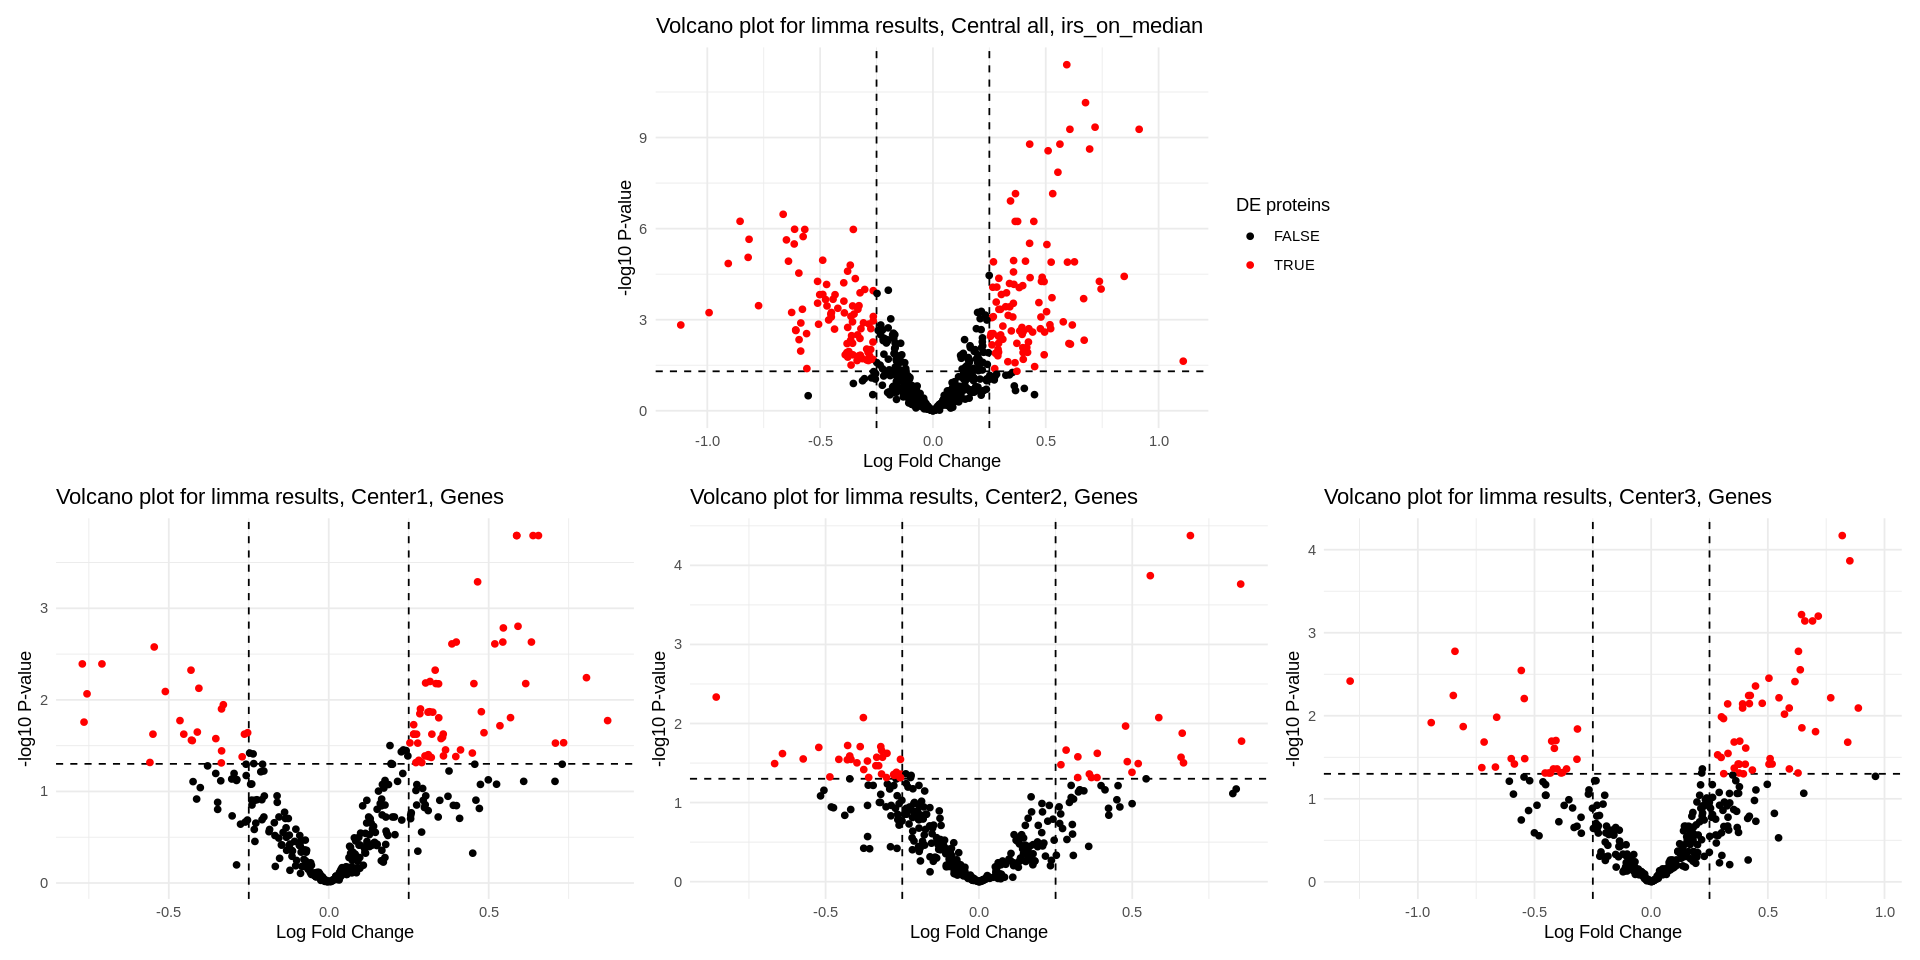

In [101]:
x <- ggplot() + theme_void()
layout <- (x | volcano_plot(results_irs_on_median, "Central all, irs_on_median", show_names = FALSE) | x) / 
          (plots[['Center1']] | plots[['Center2']] | plots[['Center3']])
options(repr.plot.width=16, repr.plot.height=8)
print(layout)

### run meta

In [92]:
Rscript /home/yuliya/repos/cosybio/FedProt/evaluation/meta_code/run_MetaDE.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/ Center1 Center2 Center3
Rscript /home/yuliya/repos/cosybio/FedProt/evaluation/meta_code/run_MetaVolcanoR.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/ Center1 Center2 Center3
Rscript /home/yuliya/repos/cosybio/FedProt/evaluation/meta_code/run_RankProd.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/ Center1 Center2 Center3


ERROR: Error in parse(text = x, srcfile = src): <text>:1:166: unexpected symbol
1: Rscript /home/yuliya/repos/cosybio/FedProt/evaluation/meta_code/run_MetaDE.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/ Center1 Center2
                                                                                                                                                                         ^


In [93]:
cp /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/MA_*.tsv /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/gene/

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: unexpected end of input
1: cp /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/MA_data_gene/MA_*.tsv /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/DE_results/gene/
   ^
